In [1]:
import numpy as np
from ase.io import *
from ase.data import covalent_radii
from qeq import charge_eq
from kqeq import *
import matplotlib.pyplot as plt

## Kernel QEq

To predict charges with QEq, we multiply the hardness matrix $\bar{\mathbf{A}}$ with the vector of electronegativities $\mathbf{c}$:

$$
\mathbf{q} = \bar{\mathbf{A}} \mathbf{c}
$$

We now substitute the vector of electronegativities with a KRR expression:

$$
\mathbf{c} = \mathbf{K} \alpha
$$

so that

$$
\mathbf{q} = \bar{\mathbf{A}} \mathbf{K} \alpha
$$

Finally, we can calculate the diple vector of a molecule using 3x$N$ matrix of R of center-of-mass shifted atomic coordinates:
$$
\mu = \mathbf{R}(\bar{\mathbf{A}}\mathbf{K}\alpha)
$$

We now want to determine the optimal regression weights $\alpha$. To this end we set up a regularized least-squares problem:

$$
L = ||(\mathbf{\mu}-\mathbf{\mu_{ref}})||^2 + \lambda \alpha^T \mathbf{K} \alpha = ||\mathbf{R}(\bar{\mathbf{A}}\mathbf{K}\alpha) -\mathbf{\mu_{ref}})||^2 + \lambda \alpha^T \mathbf{K} \alpha
$$

To minimize this loss function, we set $\frac{dL}{d\alpha}=0$ and solve for $\alpha$, to obtain: 

$$
\alpha = (\bar{\mathbf{A}}^T \mathbf{R}^T \mathbf{R} \bar{\mathbf{A}} \mathbf{K} + \lambda \mathbb{1})^{-1} \bar{\mathbf{A}}^T \mathbf{R}^T\mathbf{\mu_{ref}}
$$

The above equations are formulated for a single QEq problem (i.e. a single molecule or system). In practice we train on multiple systems at once. This can trivially be achieved by using a blocked matrix for $\bar{\mathbf{A}}$.

In this code, I only used the simplest possible Kernel, which evaluates as 1.0 if two atoms are of the same element and 0.0 otherwise. This is basically just a fancy way of fitting a normal QEq model, or rather the electronegativities. The other QEq hyperparameters are set via a simple heuristic: I use Gaussian smeared charges, where the broadening is proportional to the covalent radius (via the parameter `scale_atsize`) A value of 2.0 seems to work well, but this can certainly be optimized. The elemental hardness is directly derived from the on-center term of the electrostatic energy of the Gaussians, so there's no additional parameter used here (though this is implemented and could be used to make the model more flexible). The only other hyperparameter of the model is the regularization stength $\lambda$.

To extend this, you can now substitute the stupid Kernel I used by SOAP. I would expect the electronegativity to be quite short-ranged, so you can start with a cutoff like 2.0. As a baseline for the accuracy of the method we can look at the performance of the stupid Kernel for a set of 600 drug-like molecules.

In [2]:
# Fit the model 
mols = read("/home/staacke/Documents/Projects/Charge_model/QM9_bohr.xyz@:200")
print(len(mols))

#lams = np.logspace(-5,2,10)
lams = [0.1]

Q_pred, Q_ref, weights, descriptors_train = train_kQEq(mols,lams=lams,scale_atsize=[2.])

200
0.1 0.018729062887589694


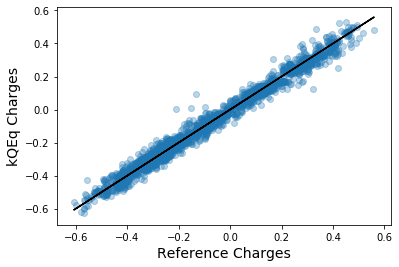

In [3]:
plt.scatter(Q_ref,Q_pred,alpha=0.3)
plt.plot(Q_ref,Q_ref,c='k')
plt.xlabel('Reference Charges',fontsize=14)
plt.ylabel('kQEq Charges',fontsize=14)

plt.show()

In [4]:
QM9mols = read("/home/staacke/Documents/Projects/Charge_model/QM9_bohr.xyz@200:")

In [5]:
len(QM9mols)

133685

In [7]:
ps=[]
for i in range(1333):
    ps.append(i*100)

In [11]:
ps

[0,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900,
 5000,
 5100,
 5200,
 5300,
 5400,
 5500,
 5600,
 5700,
 5800,
 5900,
 6000,
 6100,
 6200,
 6300,
 6400,
 6500,
 6600,
 6700,
 6800,
 6900,
 7000,
 7100,
 7200,
 7300,
 7400,
 7500,
 7600,
 7700,
 7800,
 7900,
 8000,
 8100,
 8200,
 8300,
 8400,
 8500,
 8600,
 8700,
 8800,
 8900,
 9000,
 9100,
 9200,
 9300,
 9400,
 9500,
 9600,
 9700,
 9800,
 9900,
 10000,
 10100,
 10200,
 10300,
 10400,
 10500,
 10600,
 10700,
 10800,
 10900,
 11000,
 11100,
 11200,
 11300,
 11400,
 11500,
 11600,
 11700,
 11800,
 11900,
 12000,
 12100,
 12200,
 12300,
 12400,
 12500,
 12600,
 12700,
 12800,
 12900,
 13000,
 13100,
 13200,
 13300,
 13400,
 13500,
 13600,
 13700,
 13800,


In [13]:
# Let's do some validation

q_ref,q_pred=[],[]
for i,n in enumerate(ps):
    print(n)
    Q_pred_test, Q_ref_test = Predict_Qs(QM9mols[n:ps[i+1]],descriptors_train,weights)
    q_ref.extend(Q_ref_test)
    q_pred.extend(Q_pred_test)

0
MAE= 0.020036187311319047
100
MAE= 0.02018049211150611
200
MAE= 0.02041541014355244
300
MAE= 0.01957664911887933
400
MAE= 0.019829947427353327
500
MAE= 0.021535595996476444
600
MAE= 0.021369227711524233
700
MAE= 0.021137151501742422
800
MAE= 0.02127140447567116
900
MAE= 0.02005262961166608
1000
MAE= 0.021565786365716676
1100
MAE= 0.01906900819917735
1200
MAE= 0.021420444553300402
1300
MAE= 0.02079370166832186
1400
MAE= 0.021171976264004952
1500
MAE= 0.02055794078197374
1600
MAE= 0.020986305173490788
1700
MAE= 0.019912774430499082
1800
MAE= 0.020391805313985777
1900
MAE= 0.020346931674964864
2000
MAE= 0.020762081923870645
2100
MAE= 0.020203825201037865
2200
MAE= 0.019474814664727662
2300
MAE= 0.020294641262922214
2400
MAE= 0.02045611874661449
2500
MAE= 0.01995684687080011
2600
MAE= 0.022044307692605517
2700
MAE= 0.020258820248600356
2800
MAE= 0.021180343622813774
2900
MAE= 0.020505806106255034
3000
MAE= 0.02066271086747393
3100
MAE= 0.02112855923164529
3200
MAE= 0.02107576417579608
33

MAE= 0.019047035161638803
26400
MAE= 0.020730598068777265
26500
MAE= 0.019335856459019085
26600
MAE= 0.018884945983593616
26700
MAE= 0.020553789880600037
26800
MAE= 0.021964725155159816
26900
MAE= 0.021147536957711086
27000
MAE= 0.018716902763255945
27100
MAE= 0.01989136317838744
27200
MAE= 0.021216442460693808
27300
MAE= 0.01985840442610756
27400
MAE= 0.02044940132529318
27500
MAE= 0.019729879918820453
27600
MAE= 0.02199581817525265
27700
MAE= 0.02044735623001313
27800
MAE= 0.021743002765546412
27900
MAE= 0.02053991521025034
28000
MAE= 0.020582548667687727
28100
MAE= 0.020608117512934624
28200
MAE= 0.020885281980095104
28300
MAE= 0.020689868940885387
28400
MAE= 0.020031974186521074
28500
MAE= 0.021566490517711555
28600
MAE= 0.0199525135999284
28700
MAE= 0.021275679646930154
28800
MAE= 0.02106940832954083
28900
MAE= 0.020361310814082247
29000
MAE= 0.019832518112313707
29100
MAE= 0.020505318354733067
29200
MAE= 0.020393931830015023
29300
MAE= 0.019890618969973038
29400
MAE= 0.0209686044

MAE= 0.02028629670181024
52300
MAE= 0.020977545203653282
52400
MAE= 0.01962459958157837
52500
MAE= 0.020480024345166603
52600
MAE= 0.022210372737418098
52700
MAE= 0.01966674466185362
52800
MAE= 0.01927698933536322
52900
MAE= 0.02049160143190974
53000
MAE= 0.020941077270037314
53100
MAE= 0.019221042109602664
53200
MAE= 0.020649564716892405
53300
MAE= 0.022183237886502366
53400
MAE= 0.01968242896013912
53500
MAE= 0.021006028352619954
53600
MAE= 0.02009958879768908
53700
MAE= 0.020495277343246205
53800
MAE= 0.021166117145318002
53900
MAE= 0.02002764375526617
54000
MAE= 0.02101411336561381
54100
MAE= 0.02159549563321099
54200
MAE= 0.01893618217727388
54300
MAE= 0.021052436416832902
54400
MAE= 0.02031893257004541
54500
MAE= 0.02003668442017445
54600


KeyboardInterrupt: 

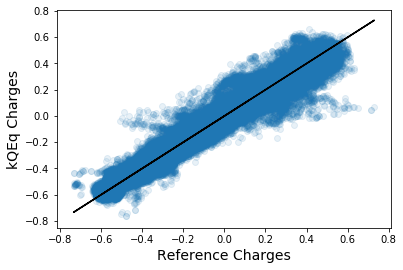

In [14]:
plt.scatter(q_ref,q_pred,alpha=0.1)
plt.plot(q_ref,q_ref,c='k')
plt.xlabel('Reference Charges',fontsize=14)
plt.ylabel('kQEq Charges',fontsize=14)

plt.show()

So this baseline model actually works reasonably well (mean accuracy is 0.05 elementary charges) when training on 200 molecules, and it generalizes well beyond the training set. But there are a lot of details that the model is not getting right, in particular for very negative charges (maybe oxygens?).

One thing to note is that the code as it is written is probably not going to work very well for huge training sets. The dimension of the largest matrices is $\mathcal{O}(N_{molecules} \times N_{atoms})$ and there are ca. 40 atoms per molecule. So a training set of 250 molecules is already quite large (10000 datapoints). It will be important to choose the training molecules to include the most important chemical environments for each element. This can be done with FPS. But it's important to not use something like the average kernel, but to really maximise the diversity of atomic environments (and to do this for each molecule separately).